# **Week 6: Biomedical Signal Processing**

First, we load and visualize a set of noisy ECG data.

ECG sample data size (108000,)


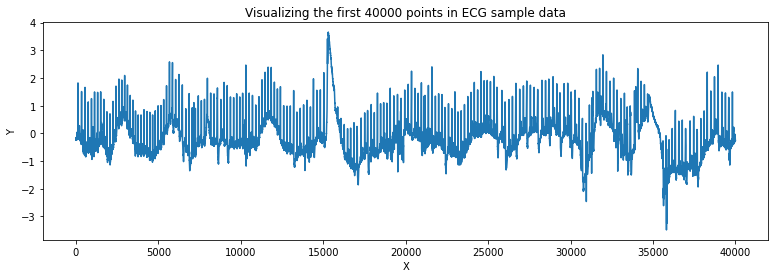

In [74]:
from numpy import loadtxt
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import electrocardiogram

data = electrocardiogram()

print('ECG sample data size',data.shape)
plt.figure(figsize=(13,4))
plt.plot(data[0:40000])
plt.title("Visualizing the first 40000 points in ECG sample data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

To better illustrate the different signal processing algorithms, we first setup a toy data. The toy data is formed by an artificial clean signal (f), an artificially generated random noise (errs). By summing the artificial clean signal "f" and the artificial noise "errs" together, we form a noisy signal (f_noisy).

The following code visualizes the toy data generated.

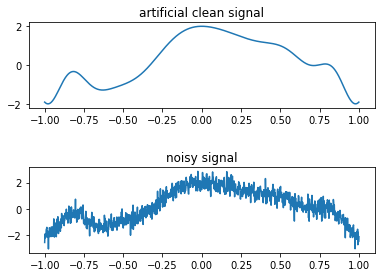

In [79]:
nsamples=1000

# forming the toy dataset
xs=np.linspace(-1,1,nsamples)
ys=xs*np.pi
f=np.cos(ys) + np.sin(ys)*np.sin(ys)*np.sin(ys)+np.cos(ys)*np.cos(ys)*np.cos(ys*ys)
errs=np.random.normal(0.0,0.4,(nsamples))
f_noisy=f+errs

#visualizing the toy dataset
fig, axs = plt.subplots(2)
plt.subplot(211)
plt.plot(xs, f)
plt.title('artificial clean signal')
plt.subplot(212)
plt.plot(xs, f_noisy)
plt.title('noisy signal')

#adjust the figure related configurations
plt.subplots_adjust(left=0.1,
          bottom=0.1, 
          right=0.9, 
          top=0.9, 
          wspace=0.4, 
          hspace=0.7)

plt.show()


# **Filtering With DWT**

The following code demonstrates how to perform filtering using DWT leveraging the toy data.

In [70]:
import pywt
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

wavelet_type='db6'
data = f_noisy

mode_used='zero'

DWTcoeffs = pywt.wavedec(data,wavelet_type,mode=mode_used, level=9, axis=-1)

hard_threshold_index=4

for i in range(hard_threshold_index):
  DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])

filtered_data_dwt=pywt.waverec(DWTcoeffs,wavelet_type,mode=mode_used,axis=-1) 


fc = 0.35  # Cut-off frequency of the butterworth filter
w = fc / (360 / 2) # Normalize the frequency

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


The frequency density of the noisy signal (blue) and the filtered signal (red) is demonstrated.

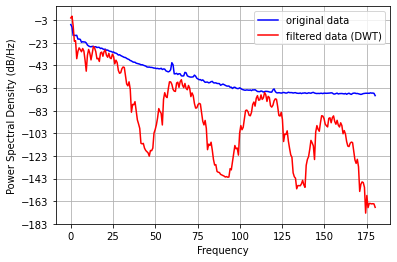

In [82]:
plt.figure(1)
plt.psd(data, NFFT=512, Fs=360, label='original data', color='blue')
plt.psd(filtered_data_dwt, NFFT=512, Fs=360, color='red', label='filtered data (DWT)')
plt.legend()

Visualizing and comparing the "noisy signal", the "filtered signal" and the "artificial clean signal".

average error for filtered signal:  0.4640242237437717


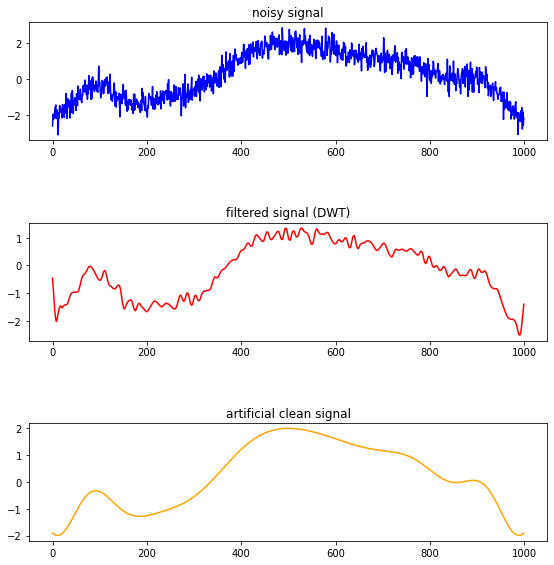

In [85]:
plt.figure(3,figsize=(9,9))
plt.subplot(311)
plt.plot(f_noisy,label='noisy signal', color='blue')
plt.title('noisy signal')
plt.subplot(312)
plt.plot(filtered_data_dwt, color='red', label='filtered signal (DWT)')
plt.title('filtered signal (DWT)')
plt.subplot(313)
plt.plot(f, color='orange', label='artificial clean signal')
plt.title('artificial clean signal')

plt.subplots_adjust(left=0.1,
          bottom=0.1, 
          right=0.9, 
          top=0.9, 
          wspace=0.4, 
          hspace=0.7)

sum=0
for i in range(len(filtered_data_dwt)):
  sum+=np.abs(filtered_data_dwt[i]-f[i])

print('average error for filtered signal: ',sum/len(filtered_data_dwt))

code modified from https://stackoverflow.com/questions/54619107/how-to-combine-wavelet-transform-and-frequency-filtering

# **Excercises:**

**Excercise 1:** Adjust the hyperparameters of the filter ((1) wavelet_type (2) mode_used (3) hard_threshold_index) so that the "average error for the filtered signal" is minimized.

**Excercise 2:** Adjust the code to perform soft-thresholding

**Excercise 3:** perform DWT filtering on the real ECG data (data = electrocardiogram()) and attempt to gain the expected result below

expected result:

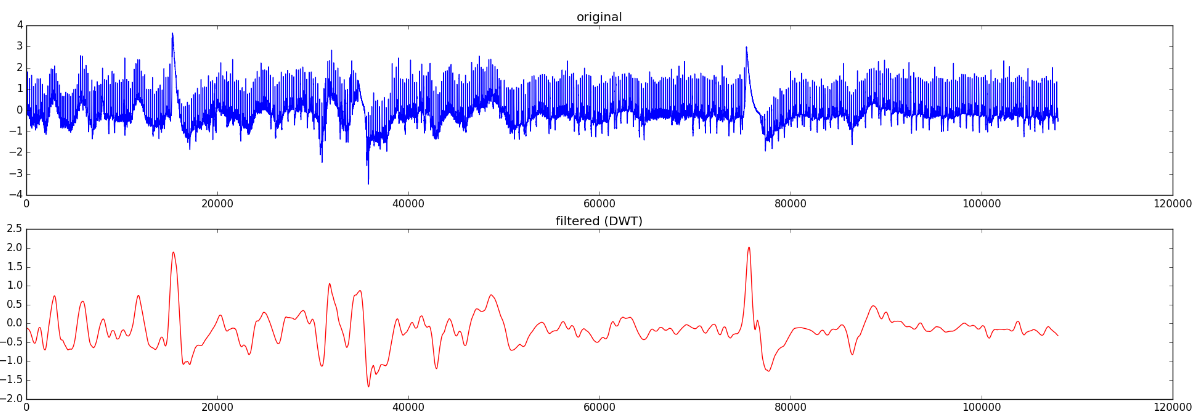

# **LMS-filtering**

The following codes demonstrate how to perform LMS-filtering using the toy data.

install the package needed for LMS-filtering

In [27]:
!pip install padasip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 4.1 MB/s 


Performing the LMS-filtering

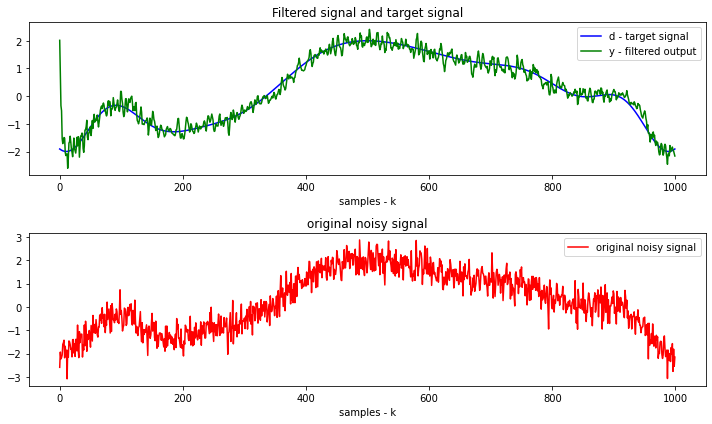

average training error:  0.015387171622157091


In [88]:
import numpy as np
import matplotlib.pylab as plt
import padasip as pa

#convert from 1-D signal to 2-D matrix
def convert_to_matrix(x,k):
  new=x.copy()
  for i in range(k-1):
    new.insert(0,0)
  new2=[]
  for i in range(len(x)):
    temp=new[i:i+k]
    new2.append(temp)
  new2=np.asarray(new2)
  return new2

# filter size
k=4

#naming/converting the toy data
x=convert_to_matrix(np.ndarray.tolist(f_noisy),k)
v=errs
d=f

# initialize the LMS-filter
filter = pa.filters.FilterLMS(n=k, mu=0.03, w="random")

# train the LMS-filter
y, e, w = filter.run(d, x)

# show results
plt.figure(figsize=(10,6))
plt.subplot(211);plt.title("Filtered signal and target signal");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target signal")
plt.plot(y,"g", label="y - filtered output");plt.legend()
plt.subplot(212);plt.title("original noisy signal");plt.xlabel("samples - k")
plt.plot(f_noisy,"r", label="original noisy signal");
plt.legend()
plt.tight_layout()
plt.show()

error_sum=0
for i in range(len(y)):
  error_sum+=y[i]-d[i]
print('average training error: ',error_sum/len(y))

Applying the trained filter on the new toy data for testing.

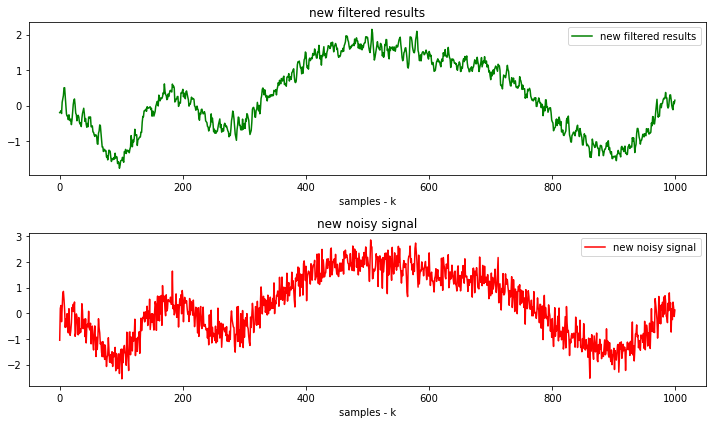

average testing error:  -0.0302307873587131


In [89]:
# new toy data
xs1=np.linspace(-1,1,nsamples)
ys1=xs*np.pi
f1=np.cos(ys1) + np.sin(ys1*ys1)*np.sin(ys1)*np.sin(ys1)*np.sin(ys1)+np.cos(ys1)*np.cos(ys1*ys1)
errs1=np.random.normal(0.0,0.4,(nsamples))
f_noisy1=f1+errs1

#naming/converting the toy data
x=convert_to_matrix(np.ndarray.tolist(f_noisy1),k)
v=errs1
d=f1

#gaining the new results
y1=[]
for i in range(len(x)):
  temp = filter.predict(x[i])
  y1.append(temp)

# show results
plt.figure(figsize=(10,6))
plt.subplot(211);plt.title("new filtered results");plt.xlabel("samples - k")
plt.plot(y1,"g", label="new filtered results");
plt.legend()
plt.subplot(212);plt.title("new noisy signal");plt.xlabel("samples - k")
plt.plot(f_noisy1,"r", label="new noisy signal");
plt.legend()
plt.tight_layout()
plt.show()

error_sum=0
for i in range(len(y1)):
  error_sum+=y1[i]-f1[i]
print('average testing error: ',error_sum/len(y1))



# **Exercises:**

**Exercise 1:** Adjust the hyperparameters in the LMS filter to minimize the average testing error. Hyperparameters that can be adjusted are (1)N, (2)k, (3)mu.

**Exercise 2:** Adjust and apply the LMS adaptive filter to the real ECG data(data = electrocardiogram()).

Code modified from https://matousc89.github.io/padasip/sources/filters/lms.html

# **Independent Component Analysis (ICA)**

The following codes demonstrate the effectiveness of ICA (relative to PCA) in terms of disentangling information leveraging a toy example.

Within the toy example, we first form three independent signals (s1, s2, s3). By generating a mixing matrix (A), we are able to first mix the three signal (X).

With the mixed-signal X, we can then try to recover the three original signals s1, s2 and s3 using both ICA and PCA. In this way, the effectiveness of the two methods can be compared.

First, the mixing is performed

In [1]:
import numpy as np
from scipy import signal

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

Then, disentangling is performed using both the ICA algorithm and the PCA algorithm.

In [2]:
from sklearn.decomposition import FastICA, PCA

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

The results are visualized. It can be observed that by leveraging ICA, the original signals have been better recovered.

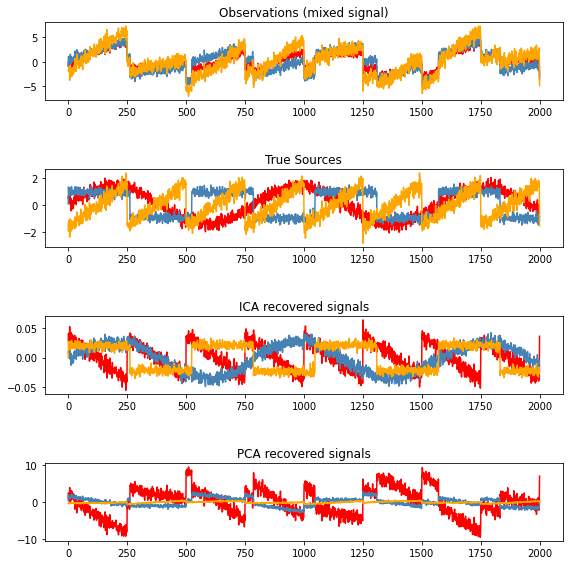

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

models = [X, S, S_, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)


#plt.tight_layout()
plt.subplots_adjust(left=0.1,
          bottom=0.1, 
          right=0.9, 
          top=0.9, 
          wspace=0.4, 
          hspace=0.9)
plt.show()

Code modified from https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py